# Simulation Analysis Graphics for Paper - Quartier Nord

by: Clayton Miller

Apr 13, 2016

In [14]:
%matplotlib inline

import esoreader
reload(esoreader)
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
import csv


In [15]:
sns.set_style("whitegrid")

# Get Co-Sim Data

In [16]:
# change this to point to where you checked out the GitHub project
PROJECT_PATH = r"/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/"

# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH,'cosimulation','quartier_nord.eso')

# yeah... we need an index for timeseries...
HOURS_IN_YEAR = pd.date_range('2013-01-01', '2013-12-31 T23:00', freq='H')

In [17]:
qn_cosim_eplus = esoreader.read_from_path(ESO_PATH)

In [28]:
qn_cosim_eplus.find_variable("Zone Ideal Loads")

[('TimeStep',
  'ZONE1ZONEHVAC:IDEALLOADSAIRSYSTEM',
  'Zone Ideal Loads Zone Total Heating Energy'),
 ('TimeStep',
  'ZONE2ZONEHVAC:IDEALLOADSAIRSYSTEM',
  'Zone Ideal Loads Zone Total Heating Energy'),
 ('TimeStep',
  'ZONE1ZONEHVAC:IDEALLOADSAIRSYSTEM',
  'Zone Ideal Loads Zone Total Cooling Energy'),
 ('TimeStep',
  'ZONE2ZONEHVAC:IDEALLOADSAIRSYSTEM',
  'Zone Ideal Loads Zone Total Cooling Energy')]

In [36]:
#qn_cosim_eplus.to_frame("Zone Total Heating Energy")

In [46]:
heating = qn_cosim_eplus.to_frame('Zone Total Heating Energy', index=HOURS_IN_YEAR)#.sum(axis=1) , use_key_for_columns=False, frequency="HOURLY"
cooling = qn_cosim_eplus.to_frame('Zone Total Cooling Energy', index=HOURS_IN_YEAR)#.sum(axis=1) , use_key_for_columns=False
df = pd.DataFrame({'Co-Simulation EnergyPlus Heating': heating.sum(axis=1), 
                    'Co-Simulation EnergyPlus Cooling': cooling.sum(axis=1)})
df_cosim_eplus = df*0.000000277777778

In [48]:
df_cosim_eplus.head()

,Co-Simulation EnergyPlus Cooling,Co-Simulation EnergyPlus Heating
2013-01-01 00:00:00,0.000000e+00,124.506683
2013-01-01 01:00:00,1.600711e-12,121.133719
2013-01-01 02:00:00,5.209586e-12,119.227970
2013-01-01 03:00:00,3.274181e-12,118.674850
2013-01-01 04:00:00,3.121386e-12,117.953171


# Get E+ Solo Data

In [56]:
# this is the output of the workflow
ESO_PATH = os.path.join(PROJECT_PATH, 'nord_only_EP', 'eplusout.eso')

In [72]:
#eplus_solo.to_frame("Zone Ideal Loads Supply Air Total Cooling Energy", frequency="HOURLY")

In [77]:
eplus_solo = esoreader.read_from_path(ESO_PATH)
heating = eplus_solo.to_frame('Zone Ideal Loads Supply Air Total Heating Energy', index=HOURS_IN_YEAR, frequency="HOURLY")#.sum(axis=1) use_key_for_columns=False, 
cooling = eplus_solo.to_frame('Zone Ideal Loads Supply Air Total Cooling Energy', index=HOURS_IN_YEAR, frequency="HOURLY")#.sum(axis=1) use_key_for_columns=False,
df = pd.DataFrame({'Solo EnergyPlus Heating': heating.sum(axis=1), 
                   'Solo EnergyPlus Cooling': cooling.sum(axis=1)})
df_solo_eplus = df*0.000000277777778

In [205]:
energyplus = pd.merge(df_solo_eplus, df_cosim_eplus, right_index=True, left_index=True, how='outer')

In [206]:
energyplus = energyplus[['Co-Simulation EnergyPlus Heating','Co-Simulation EnergyPlus Cooling','Solo EnergyPlus Heating','Solo EnergyPlus Cooling']]

In [207]:
energyplus.head()

,Co-Simulation EnergyPlus Heating,Co-Simulation EnergyPlus Cooling,Solo EnergyPlus Heating,Solo EnergyPlus Cooling
2013-01-01 00:00:00,124.506683,0.000000e+00,88.470457,0
2013-01-01 01:00:00,121.133719,1.600711e-12,90.871919,0
2013-01-01 02:00:00,119.227970,5.209586e-12,93.219381,0
2013-01-01 03:00:00,118.674850,3.274181e-12,95.474847,0
2013-01-01 04:00:00,117.953171,3.121386e-12,97.324120,0


# Get CitySim Data

In [208]:
def get_citysimdata(path,key):
    varlist = []
    hours_in_year = pd.date_range('2013-01-01', '2013-12-31 T23:00', freq='H')
    with open(path[1], 'r') as infile:
        reader = csv.DictReader(infile, dialect=csv.Sniffer().sniff(infile.read(1000)))
        infile.seek(0)
        for row in reader:
            varlist.append(float(row[key]))
    #colname = key[0]+" "+path[0]
    df = pd.DataFrame({key:pd.Series(varlist,index=hours_in_year)})
    #outputdf = pd.DataFrame({path[0]+" Heating":df[df<0], path[0]+" Cooling":df[df>0]})
    outputdf = pd.merge(np.abs(df[df<0]), df[df>0], right_index=True, left_index=True)
    outputdf = outputdf.fillna(0)/1000
    outputdf.columns = [path[0]+" Cooling",path[0]+" Heating"]
    return outputdf


In [209]:
citysim_solo = get_citysimdata(['Solo CitySim',r'/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/nord_only_CitySim/nord_only_CitySim_TH.out'], '1(1):1:Qs(Wh)')

In [210]:
citysim_cosim = get_citysimdata(['Co-Simulation CitySim',r'/Users/Clayton/Dropbox/UMEM/Quartier_Nord_EPFL/cosimulation/quartier_nord_TH.out'], '1(1):1:Qs(Wh)')

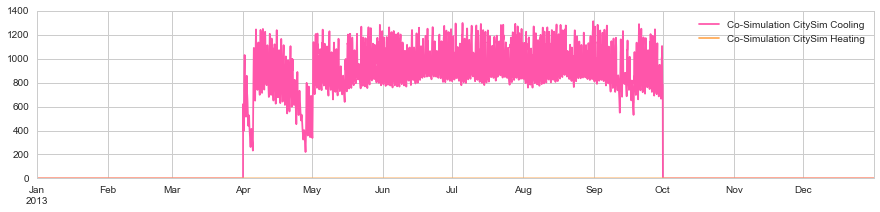

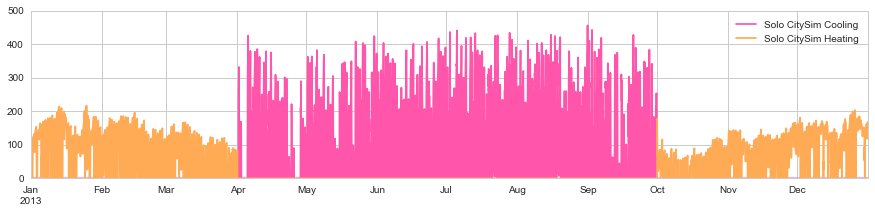

In [311]:
citysim_cosim.plot(figsize=(15,3))
citysim_solo.plot(figsize=(15,3))

In [212]:
city_sim = pd.merge(citysim_cosim, citysim_solo, right_index=True, left_index=True)

In [213]:
city_sim.columns

Index([u'Co-Simulation CitySim Cooling', u'Co-Simulation CitySim Heating',
       u'Solo CitySim Cooling', u'Solo CitySim Heating'],
      dtype='object')

In [214]:
city_sim = city_sim[['Co-Simulation CitySim Cooling','Solo CitySim Cooling','Co-Simulation CitySim Heating','Solo CitySim Heating']]

# Plot comparisons

In [275]:
def plot_comparison(df, colorpalette, filename, title, colabbrev, ylabel1, ylabel2):
    current_palette = sns.color_palette(colorpalette, 4)
    sns.set_palette(current_palette)


    fig1 = plt.figure(figsize=[15,3])
    fig1.suptitle(title, fontsize=14,y=1.02)

    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    xfmt = ScalarFormatter()
    xfmt.set_powerlimits((-3,3))
    ax1 = fig1.add_subplot(gs[:,0:72])
    styles1 = ['s-','^-','<-','-H']
    
    df_toplot = df.resample("W",how='sum')
    df_toplot.columns = colabbrev
    df_toplot.plot(style=styles1, ax=ax1)
    ax1.set_ylabel(ylabel1)
    gca().yaxis.set_major_formatter(xfmt)

    
    df_bar_combined = df.resample('A',how='sum')
    df_bar_combined.columns = colabbrev
    ax3 = fig1.add_subplot(gs[:,80:100])
    gca().yaxis.set_major_formatter(xfmt)

    df_bar_combined.T.plot(kind='bar',color=current_palette, legend=False, ax=ax3)
    ax3.set_ylabel(ylabel2)
    ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=30)
    for tick in ax3.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")

    plt.subplots_adjust(bottom=0.5)
    plt.savefig("/Users/Clayton/umem-jbps-paper/latex/figures/"+filename,bbox_inches='tight')
    plt.show()

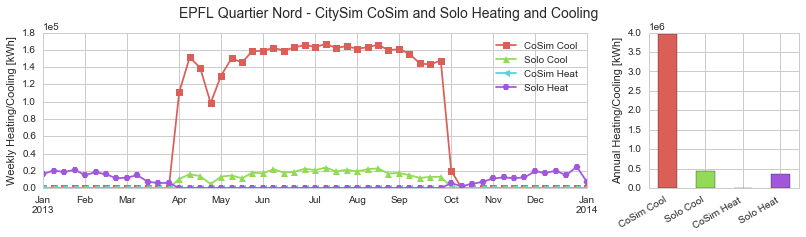

In [276]:
plot_comparison(city_sim, "hls", "QN_CitySim.pdf", "EPFL Quartier Nord - CitySim CoSim and Solo Heating and Cooling",["CoSim Cool","Solo Cool","CoSim Heat","Solo Heat"], "Weekly Heating/Cooling [kWh]","Annual Heating/Cooling [kWh]")

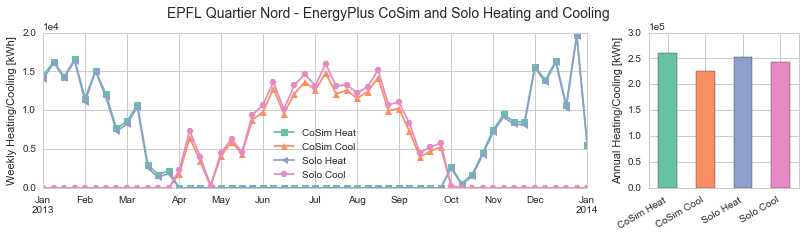

In [277]:
plot_comparison(energyplus, "Set2", "QN_EnergyPlus.pdf", "EPFL Quartier Nord - EnergyPlus CoSim and Solo Heating and Cooling",["CoSim Heat","CoSim Cool","Solo Heat","Solo Cool"], "Weekly Heating/Cooling [kWh]","Annual Heating/Cooling [kWh]")

In [278]:
allheating = pd.merge(energyplus[["Co-Simulation EnergyPlus Heating","Solo EnergyPlus Heating"]], city_sim[["Co-Simulation CitySim Heating","Solo CitySim Heating"]],right_index=True, left_index=True)

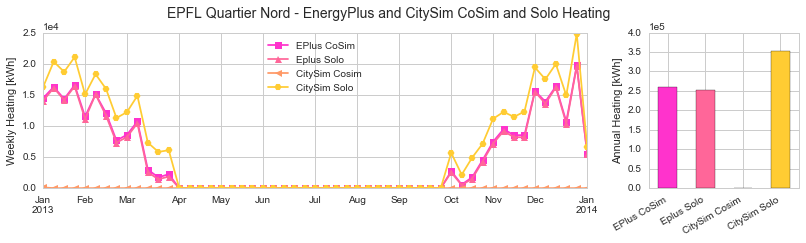

In [279]:
plot_comparison(allheating, "spring", "QN_Heating.pdf", "EPFL Quartier Nord - EnergyPlus and CitySim CoSim and Solo Heating",["EPlus CoSim","Eplus Solo","CitySim Cosim","CitySim Solo"],"Weekly Heating [kWh]","Annual Heating [kWh]")

In [280]:
allcooling = pd.merge(energyplus[["Co-Simulation EnergyPlus Cooling","Solo EnergyPlus Cooling"]], city_sim[["Co-Simulation CitySim Cooling","Solo CitySim Cooling"]],right_index=True, left_index=True)

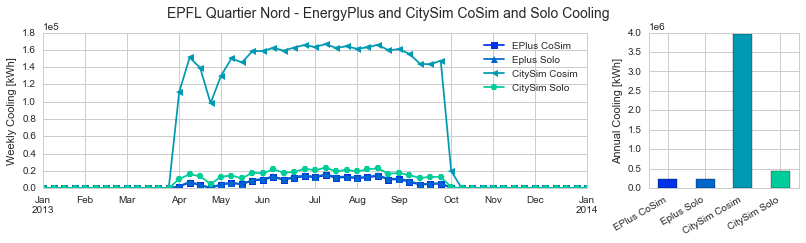

In [281]:
plot_comparison(allcooling, "winter", "QN_Cooling.pdf", "EPFL Quartier Nord - EnergyPlus and CitySim CoSim and Solo Cooling",["EPlus CoSim","Eplus Solo","CitySim Cosim","CitySim Solo"], "Weekly Cooling [kWh]","Annual Cooling [kWh]")

# Make the heating and cooling co-sim vs. solo charts

In [282]:
city_sim_annual = city_sim.resample('A',how='sum')

In [283]:
city_sim.columns

Index([u'Co-Simulation CitySim Cooling', u'Solo CitySim Cooling',
       u'Co-Simulation CitySim Heating', u'Solo CitySim Heating'],
      dtype='object')

In [284]:
def pivot_day(df, cols, startdate, enddate):
    df_forpiv = df.truncate(before=startdate, after=enddate).resample('2H', how='mean')
    #df_cooling_forpiv.columns = ["1","2","3","4"]

    df_forpiv['Date'] = df_forpiv.index.map(lambda t: t.date())
    df_forpiv['Time'] = df_forpiv.index.map(lambda t: t.time())

    df_pivot_1 = pd.pivot_table(df_forpiv, values=cols[0], index='Date', columns='Time')
    df_pivot_2 = pd.pivot_table(df_forpiv, values=cols[1], index='Date', columns='Time')
#     df_pivot_3 = pd.pivot_table(df_forpiv, values=cols[2], index='Date', columns='Time')
#     df_pivot_4 = pd.pivot_table(df_forpiv, values=cols[3], index='Date', columns='Time')

    df_pivot_sum = pd.DataFrame()
    df_pivot_sum[cols[0]] = df_pivot_1.mean()#.plot(figsize=(20,8))
    df_pivot_sum[cols[1]] = df_pivot_2.mean()#.plot()
#     df_pivot_sum[cols[2]] = df_pivot_3.mean()#.plot()
#     df_pivot_sum[cols[3]] = df_pivot_4.mean()#.plot()
    
    return df_pivot_sum

In [305]:
def plot_cosim_vs_solo(df, df_pivot, colorpalette, ylabel1, ylabel2, ylabel3, filename, title, colnames):
    current_palette = sns.color_palette(colorpalette, 2)
    sns.set_palette(current_palette)

    fig1 = plt.figure(figsize=[15,3])
    fig1.suptitle(title, fontsize=14, y=1.03)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    xfmt = ScalarFormatter()
    xfmt.set_powerlimits((-3,3))
    
    ax1 = fig1.add_subplot(gs[:,1:35])
    styles1 = ['s-','^-','<-']
    df.columns = colnames
    df_pivot.columns = colnames
    df_pivot.plot(style=styles1, ax=ax1, xticks=arange(0, 86400, 21600))

    ax1.set_ylabel(ylabel1)
    ax1.set_xlabel("Time of Day")
    gca().yaxis.set_major_formatter(xfmt)
    
    ax2 = fig1.add_subplot(gs[:,41:75])
    styles1 = ['s-','^-','<-']
    
    df.resample('M',how='sum').plot(style=styles1, ax=ax2)#.legend(loc='center left', bbox_to_anchor=(0, -0.5),), title="Monthly Total"
    ax2.set_ylabel(ylabel2)
    ax2.set_xlabel("Months of Year")

    gca().yaxis.set_major_formatter(xfmt)

    # df_netradiation.resample('M',how='sum').plot(style=styles1, ax=ax2, title="Monthly Total All Surfaces")#.legend(loc='center left', bbox_to_anchor=(0, -0.5),)
    # ax2.set_ylabel("Monthly Net Thermal Radiation [J]")
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'));

    df_bar = df.resample('A',how='sum')
    #df_bar.columns = ["CoSim","Solo"] #,"3","4"
    ax3 = fig1.add_subplot(gs[:,81:100])
    df_bar.T.plot(kind='bar',color=current_palette, legend=False, ax=ax3) #, title="Annual Total"
    ax3.set_ylabel(ylabel3)
    gca().yaxis.set_major_formatter(xfmt)

#     ax3.annotate(Exp2Annontate, xy=(0, 8000), xytext=(0.7, df_annual["2_C_NS"][0]+400))
#     ax3.annotate(Exp3Annontate, xy=(0, 8000), xytext=(1.7, df_annual["3_S_WS"][0]+400))
#     ax3.annotate(Exp4Annontate, xy=(0, 8000), xytext=(2.7, df_annual["4_C_WS"][0]+400))

#     ax3.annotate(Exp2Annontate2, xy=(0, 8000), xytext=(0.8, df_annual["2_C_NS"][0]+3500))
#     ax3.annotate(Exp3Annontate2, xy=(0, 8000), xytext=(1.8, df_annual["3_S_WS"][0]+3500))
#     ax3.annotate(Exp4Annontate2, xy=(0, 8000), xytext=(2.8, df_annual["4_C_WS"][0]+3500))

    # ax2.set_xticklabels(colnames, rotation=80)
    plt.subplots_adjust(bottom=0.5)
    # plt.tight_layout()
    plt.savefig("/Users/Clayton/umem-jbps-paper/latex/figures/"+filename,bbox_inches='tight')
    plt.show()

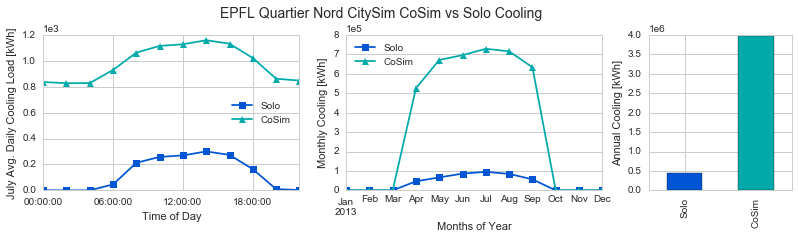

In [306]:
city_sim_cooling = city_sim[['Solo CitySim Cooling','Co-Simulation CitySim Cooling']]
city_sim_cooling_pivot = pivot_day(city_sim_cooling, list(city_sim_cooling.columns), '2013-07-01','2013-07-31')
plot_cosim_vs_solo(city_sim_cooling, city_sim_cooling_pivot, "winter", "July Avg. Daily Cooling Load [kWh]", "Monthly Cooling [kWh]", "Annual Cooling [kWh]", "QN_CitySim_Cooling.pdf","EPFL Quartier Nord CitySim CoSim vs Solo Cooling",["Solo","CoSim"])

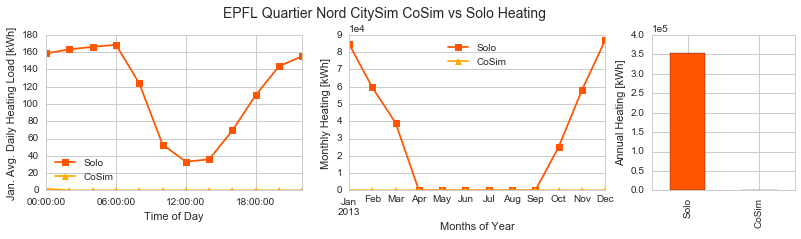

In [307]:
city_sim_heating = city_sim[['Solo CitySim Heating','Co-Simulation CitySim Heating']]
city_sim_heating_pivot = pivot_day(city_sim_heating, list(city_sim_heating.columns), '2013-01-01','2013-01-31')
plot_cosim_vs_solo(city_sim_heating, city_sim_heating_pivot, "autumn", "Jan. Avg. Daily Heating Load [kWh]", "Monthly Heating [kWh]", "Annual Heating [kWh]", "QN_CitySim_Heating.pdf","EPFL Quartier Nord CitySim CoSim vs Solo Heating",["Solo","CoSim"])

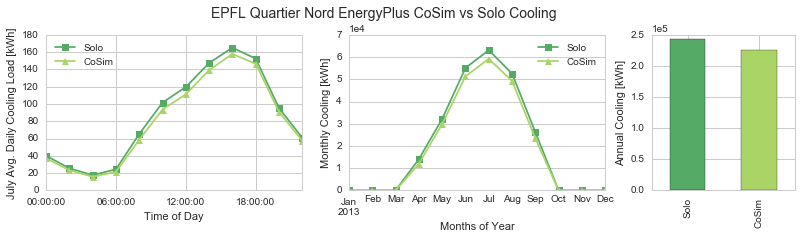

In [308]:
energyplus_cooling = energyplus[['Solo EnergyPlus Cooling','Co-Simulation EnergyPlus Cooling']]
energyplus_cooling_pivot = pivot_day(energyplus_cooling, list(energyplus_cooling.columns), '2013-07-01','2013-07-31')
plot_cosim_vs_solo(energyplus_cooling, energyplus_cooling_pivot, "summer", "July Avg. Daily Cooling Load [kWh]", "Monthly Cooling [kWh]", "Annual Cooling [kWh]", "QN_EnergyPlus_Cooling.pdf","EPFL Quartier Nord EnergyPlus CoSim vs Solo Cooling",["Solo","CoSim"])

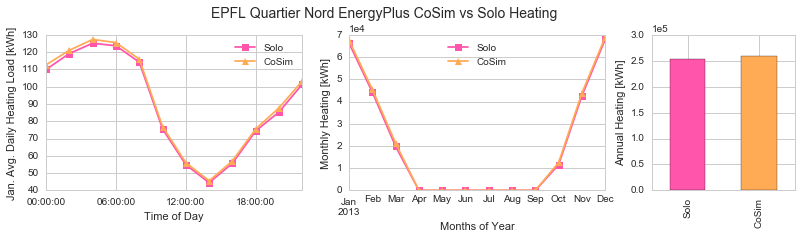

In [309]:
energyplus_heating = energyplus[['Solo EnergyPlus Heating','Co-Simulation EnergyPlus Heating']]
energyplus_heating_pivot = pivot_day(energyplus_heating, list(energyplus_heating.columns), '2013-01-01','2013-01-31')
plot_cosim_vs_solo(energyplus_heating, energyplus_heating_pivot, "spring", "Jan. Avg. Daily Heating Load [kWh]", "Monthly Heating [kWh]", "Annual Heating [kWh]", "QN_EnergyPlus_Heating.pdf","EPFL Quartier Nord EnergyPlus CoSim vs Solo Heating",["Solo","CoSim"])